# Rule: **simplify_network**

**Summary** (from *simplify_network.py*)

Lifts electrical transmission network to a single 380 kV voltage layer, removes
dead-ends of the network, and reduces multi-hop HVDC connections to a single
link.

**Outputs**

- resources/networks/`elec_s{simpl}.nc`

- resources/`regions_onshore_elec_s{simpl}.geojson`

- resources/`regions_offshore_elec_s{simpl}.geojson`

- resources/`busmap_elec_s{simpl}.csv`

**Description** (from *simplify_network.py*)

The rule does up to four things:

1. Create an equivalent transmission network in which all voltage levels are mapped to the 380 kV level by the function ``simplify_network(...)``.

2. DC only sub-networks that are connected at only two buses to the AC network are reduced to a single representative link in the function ``simplify_links(...)``. The components attached to buses in between are moved to the nearest endpoint. The grid connection cost of offshore wind generators are added to the capital costs of the generator.

3. Stub lines and links, i.e. dead-ends of the network, are sequentially removed from the network in the function ``remove_stubs(...)``. Components are moved along.

4. Optionally, if an integer were provided for the wildcard ``{simpl}`` (e.g. ``networks/elec_s500.nc``), the network is clustered to this number of clusters with the routines from the ``cluster_network`` rule with the function ``cluster_network.cluster(...)``. This step is usually skipped!

**Comments:**

- Changes with respect to `add_electricity` notebook are due to the reduction in the number of buses (thus, Voronoi cells). Slight changes can be appraised in the maps below.

- **buses**: some features disappear, like "symbol", "under_construction", "onshore_bus", ...

- `PHS` and `hydro` do not change in total capacity, but they do in hours and individual capacity

In [47]:
import pypsa
import pandas as pd
import geopandas as gpd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import yaml
import os 
import sys


##### Local funs
funs_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'local_funs'))
sys.path.append(funs_path)

from fun_map_add_features import fun_map_add_features

from fun_map_network_geometry import fun_map_network_geometry
from fun_map_network_generators import fun_map_network_generators
from fun_map_network_loads import fun_map_network_loads
from fun_map_network_storage_units import fun_map_network_storage_units

from fun_map_NUTS_geometry import fun_map_NUTS_geometry
from fun_map_NUTS_generators import fun_map_NUTS_generators
from fun_map_NUTS_loads import fun_map_NUTS_loads
from fun_map_NUTS_storage_units import fun_map_NUTS_storage_units




##### Warnings setup
import warnings
warnings.filterwarnings('ignore', category=UserWarning)



In [48]:
######################################## Parameters

##### Network parameters
simpl = ''


##### Read config file
with open('../config.yaml', 'r') as configfile:
    config = yaml.safe_load(configfile)

# Unwrap variables 
rootpath = config['notebook']['rootpath']
prefix = config['notebook']['prefix']
name = config['notebook']['name']

boundaries_onshore = config['map']['boundaries_onshore']
boundaries_offshore = config['map']['boundaries_offshore']

## `elec_s{simpl}.nc`

Load the network and show components.

In [49]:
file = f'elec_s{simpl}.nc'
path = f'{rootpath}/resources/{prefix}/{name}/networks/'

n = pypsa.Network(path+file)

n

INFO:pypsa.io:Imported network elec_s.nc has buses, carriers, generators, lines, links, loads, shapes, storage_units


PyPSA Network 'PyPSA-Spain'
Components:
 - Bus: 753
 - Carrier: 12
 - Generator: 2310
 - Line: 1179
 - Link: 1
 - Load: 421
 - Shape: 820
 - StorageUnit: 78
Snapshots: 8760

Plot the network.

Text(0.5, 1.0, 'elec_s.nc')

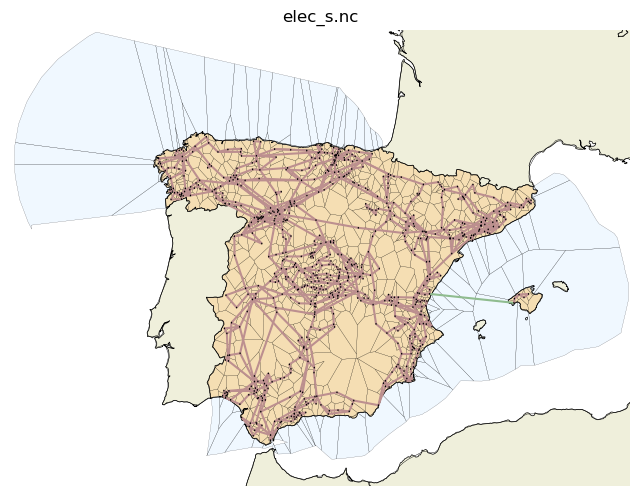

In [50]:
#################### Parameters
bus_sizes = 0.0005
bus_colors = 'black'



#################### Plot map

fig_size = [8,12]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


### Add network
n.plot(ax=ax, bus_sizes=bus_sizes, bus_colors=bus_colors, boundaries=boundaries_offshore)

### Add network geometry
fun_map_network_geometry(n, ax, domain='both')

### Add features
fun_map_add_features(ax)


ax.set_title('elec_s.nc')

### Variable: `n.generators`

Store `n.generators` in a dataFrame.

In [51]:
gg = n.generators

#### Maps

Plot a map showing a specific feature of a carrier at each Voronoi cell.

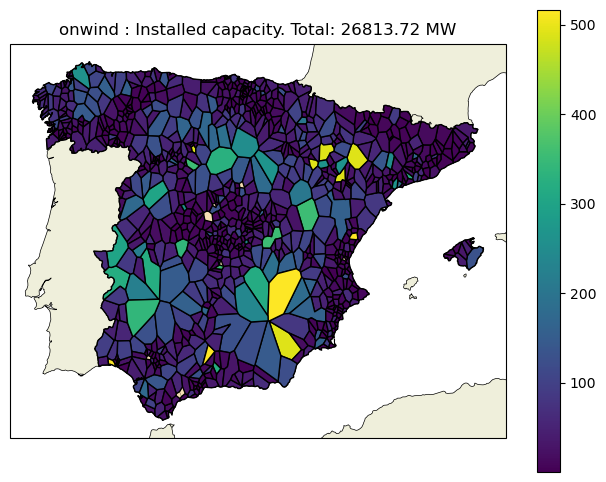

In [52]:
#################### Parameters

##### Select carrier
carrier = 'onwind'

##### Select feature. Uncomment one of the following:
# feature = 'area' 
feature = 'p_nom'
# feature = 'p_nom_density'
# feature = 'p_nom_max'
# feature = 'p_nom_max_density'
# feature = 'p_nom_max_ratio'



#################### Derived parameters
if 'off' in carrier:
    domain = 'offshore'
else:
    domain = 'onshore'



#################### Plot map

fig_size = [8,6]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


### Add network geometry
fun_map_network_geometry(n, ax, domain)

### Add network capacity at Voronoi cells
fun_map_network_generators(carrier, n, feature, ax)

### Add features
fun_map_add_features(ax)




Plot the same but aggregated to a specific NUTS level.

(For **PyPSA-Spain**, you can use NUTS files stored in folder `data_ES/`).

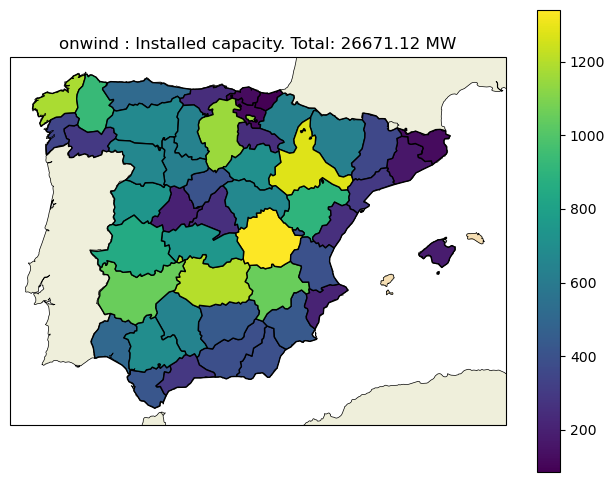

In [53]:
#################### Parameters

##### Select carrier
carrier = 'onwind'

##### Select feature. Uncomment one of the following:
# feature = 'area_NUTS' 
feature = 'weighted_p_nom'
#feature = 'weighted_p_nom_density'
#feature = 'weighted_p_nom_max'
#feature = 'weighted_p_nom_max_density'
#feature = 'weighted_p_nom_max_ratio'


##### Retrieve gdf_NUTS (it must contain at least columns 'NUTS_ID' and 'geometry')
NUTS_level = '3' 

file_NUTS = f'NUTS{NUTS_level}_ES.geojson'
path_NUTS = f'{rootpath}/data_ES/nuts/'
gdf_NUTS = gpd.read_file(path_NUTS+file_NUTS)

# Remove some regions
NUTS_initials_to_remove = ['ES70',   # Canary islands
                           'ES63',  # Ceuta
                           'ES64']  # Melilla

gdf_NUTS = gdf_NUTS[~gdf_NUTS['NUTS_ID'].apply(lambda x: any(x.startswith(prefijo) for prefijo in NUTS_initials_to_remove))]



#################### Plot map

fig_size = [8,6]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


### Add network geometry
fun_map_NUTS_geometry(gdf_NUTS, ax)

### Add network capacity at NUTS regions
fun_map_NUTS_generators(carrier, n, gdf_NUTS, feature, ax)

### Add features
fun_map_add_features(ax)

### Variable: `n.loads_t`

Store `n.loads_t` in a dataFrame.

In [54]:
lo_t = n.loads_t['p_set']

#### Maps

Plot a map showing a specific feature of the load at each Voronoi cell.

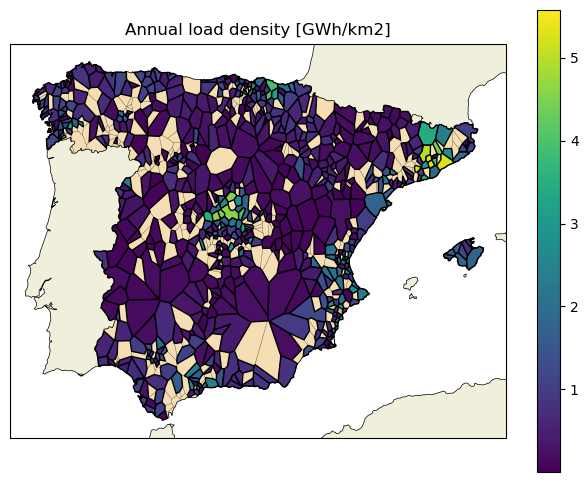

In [55]:
#################### Parameters

##### Select feature. Uncomment one of the following:
# feature = 'area' 
# feature = 'annual_load'
feature = 'annual_load_density'



#################### Plot map

fig_size = [8,6]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


### Add network geometry
fun_map_network_geometry(n, ax, 'onshore')

### Add network capacity at Voronoi cells
fun_map_network_loads(n, feature, ax)

### Add features
fun_map_add_features(ax)




Plot the same but aggregated to a specific NUTS level.

(For **PyPSA-Spain**, you can use NUTS files stored in folder `data_ES/`).

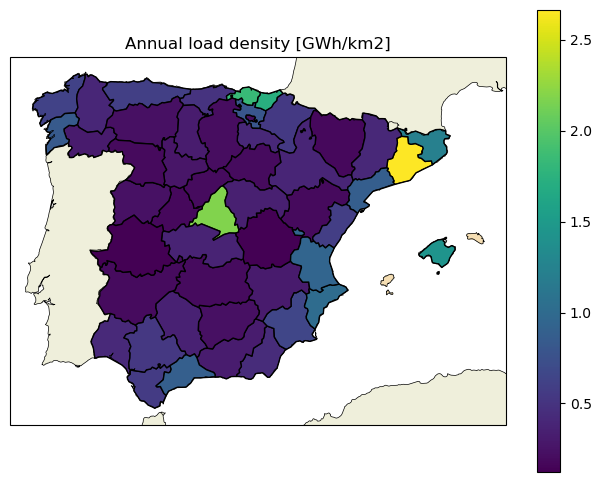

In [56]:
#################### Parameters

##### Select feature. Uncomment one of the following:
# feature = 'area_NUTS' 
# feature = 'weighted_annual_load'
feature = 'weighted_annual_load_density'


##### Retrieve gdf_NUTS (it must contain at least columns 'NUTS_ID' and 'geometry')
NUTS_level = '3' 

file_NUTS = f'NUTS{NUTS_level}_ES.geojson'
path_NUTS = f'{rootpath}/data_ES/nuts/'
gdf_NUTS = gpd.read_file(path_NUTS+file_NUTS)

# Remove some regions
NUTS_initials_to_remove = ['ES70',   # Canary islands
                           'ES63',  # Ceuta
                           'ES64']  # Melilla

gdf_NUTS = gdf_NUTS[~gdf_NUTS['NUTS_ID'].apply(lambda x: any(x.startswith(prefijo) for prefijo in NUTS_initials_to_remove))]



#################### Plot map

fig_size = [8,6]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


### Add network geometry
fun_map_NUTS_geometry(gdf_NUTS, ax)

### Add network capacity at NUTS regions
fun_map_NUTS_loads(n, gdf_NUTS, feature, ax)

### Add features
fun_map_add_features(ax)

### Variable: `n.storage_units`

Store `n.storage_units` in a dataFrame.

In [57]:
su = n.storage_units

#### Maps

Plot a map showing a specific feature of a carrier at each Voronoi cell.

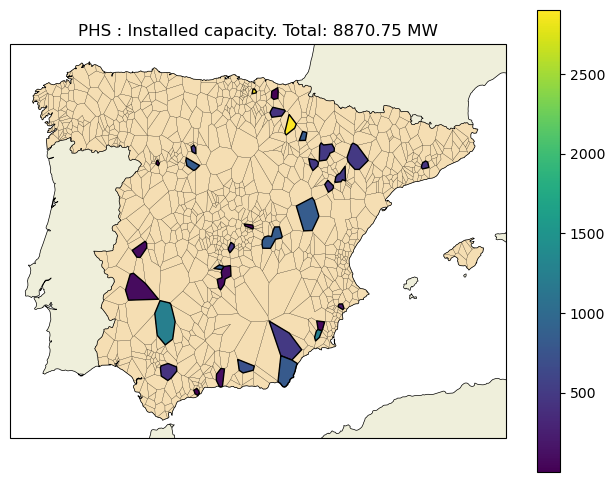

In [58]:
#################### Parameters

##### Select carrier
carrier = 'PHS'

##### Select feature. Uncomment one of the following:
# feature = 'area' 
feature = 'p_nom'
# feature = 'p_nom_density'



#################### Plot map

fig_size = [8,6]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


### Add network geometry
fun_map_network_geometry(n, ax, 'onshore')

### Add network capacity at Voronoi cells
fun_map_network_storage_units(carrier, n, feature, ax)

### Add features
fun_map_add_features(ax)




Plot the same but aggregated to a specific NUTS level.

(For **PyPSA-Spain**, you can use NUTS files stored in folder `data_ES/`).

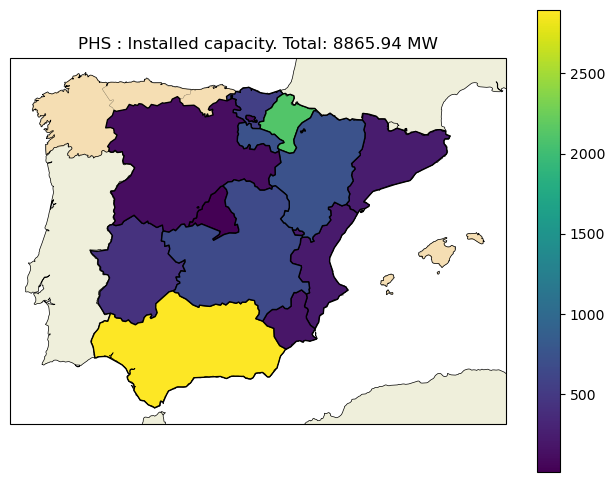

In [60]:
#################### Parameters

##### Select carrier
carrier = 'PHS'

##### Select feature. Uncomment one of the following:
# feature = 'area_NUTS' 
feature = 'weighted_p_nom'
#feature = 'weighted_p_nom_density'


##### Retrieve gdf_NUTS (it must contain at least columns 'NUTS_ID' and 'geometry')
NUTS_level = '2' 

file_NUTS = f'NUTS{NUTS_level}_ES.geojson'
path_NUTS = f'{rootpath}/data_ES/nuts/'
gdf_NUTS = gpd.read_file(path_NUTS+file_NUTS)

# Remove some regions
NUTS_initials_to_remove = ['ES70',   # Canary islands
                           'ES63',  # Ceuta
                           'ES64']  # Melilla

gdf_NUTS = gdf_NUTS[~gdf_NUTS['NUTS_ID'].apply(lambda x: any(x.startswith(prefijo) for prefijo in NUTS_initials_to_remove))]



#################### Plot map

fig_size = [8,6]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


### Add network geometry
fun_map_NUTS_geometry(gdf_NUTS, ax)

### Add network capacity at NUTS regions
fun_map_NUTS_storage_units(carrier, n, gdf_NUTS, feature, ax)

### Add features
fun_map_add_features(ax)